# Explore the Data and run Statistical Tests

This notebook runs a few exploratory tests in the first part and then some more advanced statistical tests. It displays a few plots to highlights trends in our nfl/cfb/combine data. Before doing so, we set the dataframe to only include the feature variables and our target: **the total number of receiving yards during the first 5 seasons in the NFL**

### Importing packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests

In [5]:
tdc = pd.read_csv('data_sets/tdc_ready_for_export.csv')

### Keep only features and target of interest

This include getting the total number of yards during first 5 seasons from each list of nfl_yards_per_year

In [40]:
# columns of interest
tdcf = tdc[['cfb_school', 'cfb_conference', 'cfb_class', 'cfb_pos', 'cfb_games','cfb_receptions', 
            'cfb_rec_yards', 'cfb_rec_yards_per_reception','cfb_rec_td', 'cfb_rushes', 
            'cfb_rushing_yards','cfb_rushing_yards_per_rush', 'cfb_rushing_td', 'cfb_plays',
            'cfb_yards', 'cfb_yards_per_play', 'cfb_td',
            'combine_draft_age', 'combine_ht', 'combine_wt', 'combine_forty','combine_vertical', 
            'combine_benchreps', 'combine_broadjump','combine_cone', 'nfl_yards_per_year']]

In [31]:
# keep only first five years and drop the nfl_yards_per_year
def get_first_five_seasons_yards(series):
    # the lists in nfl_yards_per_year are stored as '[year1, year2, ...]'
    # create a list of strings and remove the outside apostrophes
    lstring = series[1:-1].split(",")
    # convert each string to float
    lfloat = [float(j) for j in lstring]
    # sum first five elements
    return np.sum(lfloat[:5])

tdcf.loc[:,'rec_yards_ffs'] = tdcf.nfl_yards_per_year.apply(get_first_five_seasons_yards).tolist()
tdcf = tdcf.drop('nfl_yards_per_year', axis = 1)

In [56]:
# tdcf.to_csv(r'data_sets/tdcf.csv', index = False)
tdcf = pd.read_csv('data_sets/tdcf.csv')

In [58]:
tdcf.head(3)

,cfb_school,cfb_conference,cfb_class,cfb_pos,cfb_games,cfb_receptions,cfb_rec_yards,cfb_rec_yards_per_reception,cfb_rec_td,cfb_rushes,...,cfb_td,combine_draft_age,combine_ht,combine_wt,combine_forty,combine_vertical,combine_benchreps,combine_broadjump,combine_cone,rec_yards_ffs
0,Clemson,ACC,JR,WR,36.0,240.0,3391.0,14.1,27.0,52.0,...,28.0,21,73.0,211.0,4.43,34.0,16.0,126.0,6.95,3571.0
1,Texas A&M,SEC,SO,WR,26.0,151.0,2499.0,16.5,17.0,0.0,...,17.0,21,77.0,231.0,4.53,37.0,12.0,NaN,7.08,6103.0
2,LSU,SEC,NaN,WR,40.0,143.0,2340.0,16.4,12.0,7.0,...,12.0,21,71.0,198.0,4.38,38.5,7.0,122.0,6.69,5476.0


### How complete is our data?

Create a separate dataframe which only includes if the cfb data and combine data was scrapped. To that end end, we check the value of cfb_table_name and combine_method from our draft table.

In [93]:
info_complete_df = pd.DataFrame.from_dict({
    'cfb_data': tdc.cfb_table_name.apply(lambda x: 'scrapped' if x.split()[0] == 'receiving' else 'incomplete'),
    'combine_data': tdc.combine_method.apply(lambda x: 'scrapped' if x.split()[0] == 'success' else 'incomplete')
})

display(pd.crosstab(info_complete_df.cfb_data, info_complete_df.combine_data))

print('For a dataframe of size:', tdcf.shape)

combine_data,incomplete,scrapped
cfb_data,,
incomplete,25,42
scrapped,45,376


For a dataframe of size: (488, 26)


# 1) Exploring the Data

Let's first look at a few simple inferences that will tell us about the nature of our data set. We start with the distribution of our target - the cumulative receiving yards first 5 seasons - and then check how it correlates with the features, whether they're numerical or categorical.

### Distribution of our target

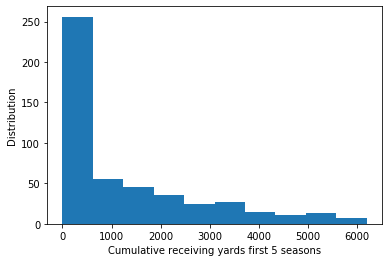

In [61]:
plt.hist(tdcf.rec_yards_ffs)
plt.xlabel('Cumulative receiving yards first 5 seasons')
plt.ylabel('Distribution')
plt.show()

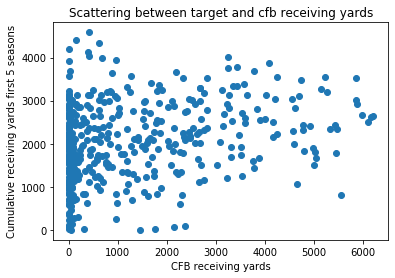

In [84]:
plt.scatter(tdcf.rec_yards_ffs, tdcf.cfb_rec_yards)
plt.xlabel('CFB receiving yards')
plt.ylabel('Cumulative receiving yards first 5 seasons')
plt.title('Scattering between target and cfb receiving yards')
plt.show()

### Correlation with Numerical Features

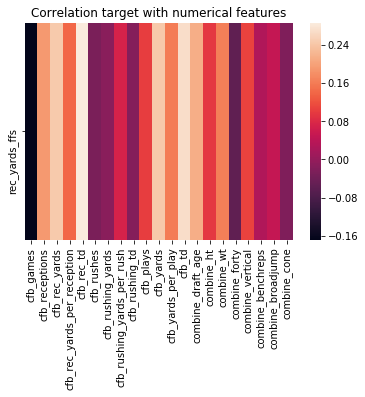

In [72]:
sns.heatmap(tdcf.corr(method='pearson').iloc[[-1],:-1], annot=False)
plt.title('Correlation target with numerical features')
plt.show()

### Impact of categorical features: cfb conference and cfb class

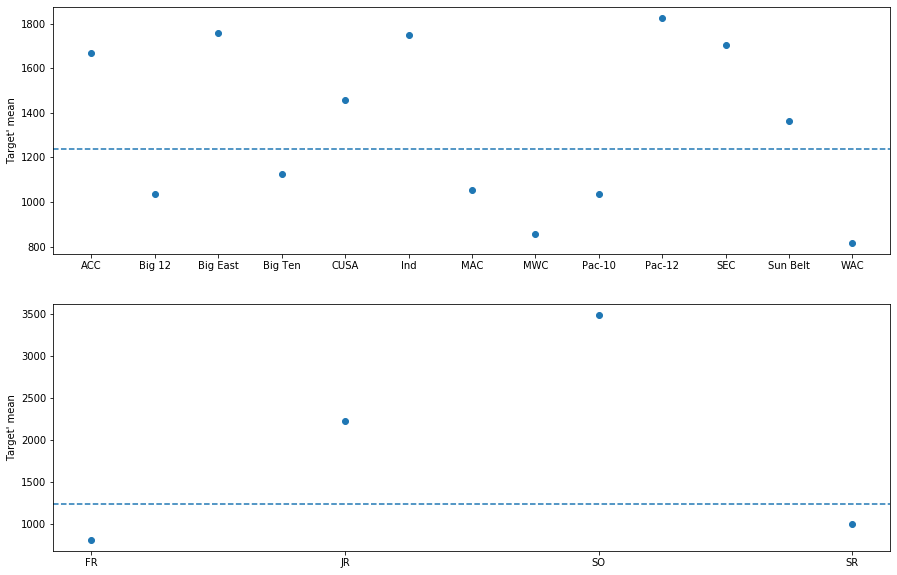

In [91]:
fig, axs = plt.subplots(2,1,figsize = (15,10))

k = 0
# group by cfb_conference and plot the mean
axs[k].plot( tdcf.groupby(['cfb_conference']).mean()['rec_yards_ffs'], marker = 'o', linestyle = '' )
axs[k].set(ylabel='Target\'s mean')
axs[k].axhline(tdcf.rec_yards_ffs.mean(), linestyle = '--')
#axs[k].title('Cumulative receiving yards first 5 seasons vs Categorical Data')

k = 1
# group by cfb_class and plot the mean
axs[k].plot(tdcf.groupby(['cfb_class']).mean()['rec_yards_ffs'], marker = 'o', linestyle = '')
axs[k].set(ylabel='Target\'s mean')
axs[k].axhline(tdcf.rec_yards_ffs.mean(), linestyle = '--')


plt.show()

### Observations and Trends

It is clear that a few of the cfb stats have a positive impact on how well the player performs in the nfl, for example: cfb_td, cfb_rec_yards, or cfb_yards. Others though, like the number of games, correlate negatively with the target. This is confirmed by the correlation matrix, whose color coding also indicates that the combine data matter a little less than the cfb one.

On the categorical front, we notice that both the conference of origin and the class status of the player has an impact on the mean observed for our target:
- for example, the SEC and the Pac-12 both perform better than average, unlike MWC and WAC
- also, juniors and sophomores do better than their freshmen and senior counterparts. Watch as the NFL won't allow FR or SO to enter the draft anymore, so those data points most likely correspond to old players

Finally, we must realize that our target is heavily skewed toward zero, i.e. it is zero inflated. This highlights the fact that a substantial number of NFL players, despite achieving great collegiate performances, get to play from very little to nothing in the big league. This poses a problem to build a linear regressor model (in addition to the data being partially incomplete and limited) which is why we will turn this into a classifier problem instead.

# 2) Statistical Analysis - Linear Analysis

Let's now run more rigorous, quantitative tests to analyse our data and what features matter or not.

### Hypothesis Testing for Difference of Means of Two Populations (via Bootstrapping)

We run a two-sample bootstrap hypothesis test for difference of means. We do so manually and on the samples of SEC vs Big12 drafted receivers.

In [100]:
def bootstraps(array, func, size):
    '''
    User-defined bootstrap function. 
    Inputs: array, the function to use (test statistic) and the size of the bootstrap
    '''
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(array, len(array)))      
    return bs_replicates

######################################

# create the two populations
sec = tdcf[tdcf['cfb_conference'] == 'SEC'].rec_yards_ffs.dropna()
big12 = tdcf[tdcf['cfb_conference'] == 'Big 12'].rec_yards_ffs.dropna()
print('The mean of SEC players is %.2f, while the Big 12 is %.2f' %(np.mean(sec), np.mean(big12)))

# compute the difference
mean_diff = np.mean(sec) - np.mean(big12)
print('The difference in means of the two samples is', mean_diff)

# concatenate and find mean
conc = np.concatenate((sec,big12))
mean_conc = np.mean(conc)

# hypothesis: assume both samples have the same mean
sec_shifted = sec - np.mean(sec) + mean_conc
big12_shifted = big12 - np.mean(big12) + mean_conc
print('Null hypothesis: the two samples have the same mean')
print('Solution: ')

# bootstrap 1000 samples separately and take difference of replicates
bs_rep_sec = bootstraps(sec_shifted, np.mean, 1000)
bs_rep_big12 = bootstraps(big12_shifted, np.mean, 1000)
bs_rep_diff = bs_rep_sec - bs_rep_big12

# p = number of replicates where difference is larger than mean difference
p = np.sum(bs_rep_diff > mean_diff)/len(bs_rep_diff)
print('The p-value for our hypothesis testing is', p)
print('We can reject the reject the null hypothesis')

The mean of SEC players is 1702.32, while the Big 12 is 1038.04
The difference in means of the two samples is 664.2787524366472
The p-value for our hypothesis testing is 0.007


### Hypothesis Testing for Difference of Means of Two Populations (via Scipy)

We re-do the same experiment, except using the t-test of scipy and w.r.t to the two samples of players that have cfb_rushes either below and above its median.

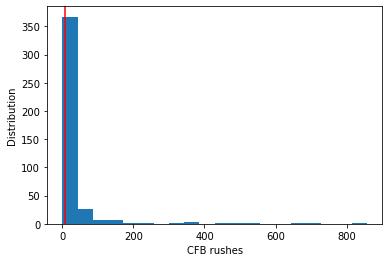

In [103]:
plt.hist(tdcf.cfb_rushes, bins = 20)
plt.axvline(tdcf.cfb_rushes.median(), color = 'r')
plt.xlabel('CFB rushes')
plt.ylabel('Distribution')
plt.show()

In [108]:
import scipy
# median of cfb_rushes
median = tdcf.cfb_rushes.median()

# populations below and above
cfbr_low = tdcf[tdcf.cfb_rushes < median].rec_yards_ffs.dropna()
cfbr_high = tdcf[tdcf.cfb_rushes >= median].rec_yards_ffs.dropna()

t, p = scipy.stats.ttest_ind(cfbr_low, cfbr_high, equal_var = False)
print('Null hypothesis: the samples of players with cfb rushes')
print('below and above the mean are from the same distribution')
print('The t-statistic and p-value returned for such hypothesis are p')
print('t =', t, 'p =', p)

Null hypothesis: the samples of players with cfb rushes
below and above the mean are from the same distribution
The t-statistic and p-value returned for such hypothesis are p
t = -0.62083510732993 p = 0.5350522491920733


# 3) Statistical Analysis - Logistic Analysis

We anticipate that this project will become a logisitic / classifier problem: we classify players as successes vs busts depending if their cumulitative receiving yards during the first 5 NFL seasons are above or below a threshold. We set that threshold to 300 yards.

In [117]:
threshold = 300
tdcf['success'] = (tdcf.rec_yards_ffs >= threshold)*1
tdcf.success.value_counts(dropna = False)

1    278
0    210
Name: success, dtype: int64

### Chi-Square Independence Test via Scipy Stats

Let's run such a test against the status of a drafted player (cfb_class). The hypothesis we test is that the two populations (juniors and seniors) are independant

In [141]:
jr = tdcf[tdcf.cfb_class == 'JR'].success.value_counts().tolist()
sr = tdcf[tdcf.cfb_class == 'SR'].success.value_counts().tolist()
array = np.array([jr, sr])

In [146]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(array)
print('The test statistic \chi', chi2)
print('The p-value:', p)
print('This means we can safely reject our hypothesis that the two populations are independant')

The test statistic \chi 34.75393475147727
The p-value: 3.741217939584596e-09
This means we can safely reject our hypothesis that the two populations are independant
